# Import

In [26]:
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import re
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputClassifier
import catboost as cb

SEED = 87656
random.seed(SEED)
np.random.seed(SEED)

DATA_DIR = pathlib.Path("data")

# Data

## Loading and preview

In [27]:
df_trends = pd.read_csv(DATA_DIR / "trends_description.csv", index_col='trend_id')
train = pd.read_csv(DATA_DIR / "train.csv", index_col='index').drop(columns='Unnamed: 0')
test = pd.read_csv(DATA_DIR / 'test.csv', index_col='index').drop(columns='Unnamed: 0')
train.head()

,assessment,tags,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,trend_id_res5,trend_id_res6,...,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49
index,,,,,,,,,,,,,,,,,,,,,
5652,6.0,"{ASSORTMENT,PROMOTIONS,DELIVERY}","Маленький выбор товаров, хотелось бы ассортиме...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18092,4.0,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}",Быстро,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13845,6.0,"{DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT}",Доставка постоянно задерживается,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25060,6.0,"{PRICE,PROMOTIONS,ASSORTMENT}",Наценка и ассортимент расстраивают,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1428,6.0,"{PRICE,PROMOTIONS}",Можно немного скинуть минимальную сумму заказа...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
df_trends.head(10)

,trend,explanation
trend_id,,
0,Долгая доставка,- долго везёте\n- очень долго везёте\n- сюда о...
1,Доставка стала долгой,"- клиент делает акцент на то, что раньше мы до..."
2,Время доставки не соответствует заявленому,"- клиент акцентирует внимание, что SLA не соот..."
3,Регулярные опоздания,"- клиент акцентриет внимание, что мы часто/каж..."
4,Не отследить реальное время доставки,"- клиент говорит о том, что невозможно понять,..."
5,Курьер на карте,- если клиент упоминает отображение курьера на...
6,Нет доставки по адресу,"клиент жалутеся, что нет доставки по адресу"
7,Не предупреждаем об удалении товара,- не предупреждаем об удалении товара\n- не пр...
8,Высокая минимальная сумма заказа,клиент жалуется на размер минимальной суммы за...


In [29]:
target_cols = list(train.columns[-50:])
num_cols = ['assessment']
text_cols = ['tags', 'text']
target_cols[::10], num_cols, text_cols

(['trend_id_res0',
  'trend_id_res10',
  'trend_id_res20',
  'trend_id_res30',
  'trend_id_res40'],
 ['assessment'],
 ['tags', 'text'])

In [30]:
train_idx = train.shape[0]
df = pd.concat((train.drop(columns=target_cols), test), axis='rows')
df.head()

,assessment,tags,text
index,,,
5652,6.0,"{ASSORTMENT,PROMOTIONS,DELIVERY}","Маленький выбор товаров, хотелось бы ассортиме..."
18092,4.0,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}",Быстро
13845,6.0,"{DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT}",Доставка постоянно задерживается
25060,6.0,"{PRICE,PROMOTIONS,ASSORTMENT}",Наценка и ассортимент расстраивают
1428,6.0,"{PRICE,PROMOTIONS}",Можно немного скинуть минимальную сумму заказа...


In [31]:
def trg_to_sub(t, indx=None):
    t = np.array(t)
    indx = range(t.shape[0]) if indx is None else indx
    target_values = []
    for row in t:
        non_zero_indices = np.nonzero(np.array(row))[0]
        if non_zero_indices.size > 0:
            target_values.append(' '.join(map(str, non_zero_indices)))
        else:
            target_values.append(np.nan)
    return pd.DataFrame({'target': target_values}, index=indx)

targets = train[target_cols]
targets_exp = trg_to_sub(targets, indx=targets.index)
targets_exp.head()

,target
index,
5652,28
18092,18
13845,3
25060,12 28
1428,8


## NaN filling

In [32]:
train.isna().sum()

assessment         0
tags              11
text               0
trend_id_res0      0
trend_id_res1      0
trend_id_res2      0
trend_id_res3      0
trend_id_res4      0
trend_id_res5      0
trend_id_res6      0
trend_id_res7      0
trend_id_res8      0
trend_id_res9      0
trend_id_res10     0
trend_id_res11     0
trend_id_res12     0
trend_id_res13     0
trend_id_res14     0
trend_id_res15     0
trend_id_res16     0
trend_id_res17     0
trend_id_res18     0
trend_id_res19     0
trend_id_res20     0
trend_id_res21     0
trend_id_res22     0
trend_id_res23     0
trend_id_res24     0
trend_id_res25     0
trend_id_res26     0
trend_id_res27     0
trend_id_res28     0
trend_id_res29     0
trend_id_res30     0
trend_id_res31     0
trend_id_res32     0
trend_id_res33     0
trend_id_res34     0
trend_id_res35     0
trend_id_res36     0
trend_id_res37     0
trend_id_res38     0
trend_id_res39     0
trend_id_res40     0
trend_id_res41     0
trend_id_res42     0
trend_id_res43     0
trend_id_res4

In [33]:
test.isna().sum()

assessment     0
tags          32
text           1
dtype: int64

In [34]:
def update_df(train, test):
    train = pd.concat((df.iloc[:train_idx], targets), axis='columns')
    test = df.iloc[train_idx:]
    return train, test

df.fillna('', inplace=True)
df.isna().sum().sum()

0

## Text processing

### Tags

In [35]:
df['tags'] = df['tags'].map(lambda x: x[1:-1].replace(',', ' '))
df.head()

,assessment,tags,text
index,,,
5652,6.0,ASSORTMENT PROMOTIONS DELIVERY,"Маленький выбор товаров, хотелось бы ассортиме..."
18092,4.0,ASSORTMENT PRICE PRODUCTS_QUALITY DELIVERY,Быстро
13845,6.0,DELIVERY PROMOTIONS PRICE ASSORTMENT SUPPORT,Доставка постоянно задерживается
25060,6.0,PRICE PROMOTIONS ASSORTMENT,Наценка и ассортимент расстраивают
1428,6.0,PRICE PROMOTIONS,Можно немного скинуть минимальную сумму заказа...


<Axes: >

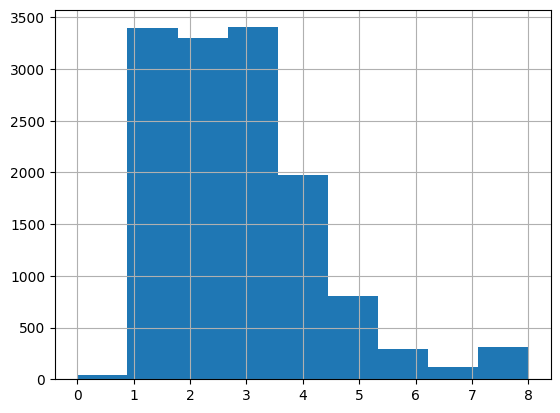

In [36]:
df['tags_num'] = df['tags'].map(lambda x: len(x.split()))
df['tags_num'].hist(bins=df['tags_num'].nunique())

In [37]:
df['no_tag'] = df['tags_num'].map(lambda x: x == 0).astype(int)

In [38]:
all_tags = set()
for t in df.tags.values:
    all_tags |= set(t.split())
    
all_tags = list(all_tags)
all_tags

['PROMOTIONS',
 'DELIVERY',
 'PRODUCTS_QUALITY',
 'SUPPORT',
 'PAYMENT',
 'PRICE',
 'CATALOG_NAVIGATION',
 'ASSORTMENT']

In [39]:
tag_translate = {
    'CATALOG_NAVIGATION': 'удобство каталога товаров',
    'PRODUCTS_QUALITY': 'качество продуктов',
    'PAYMENT': 'платежный сервис',
    'DELIVERY': 'качество доставки',
    'ASSORTMENT': 'ассортимент товаров',
    'SUPPORT': 'поддержка',
    'PROMOTIONS': 'акции в магазине',
    'PRICE': 'цены на продукты',
}
def translate_tag(tag_set):
    for tag_en in tag_set.split():
        tag_set = tag_set.replace(tag_en, tag_translate[tag_en] + ',')
    return tag_set
df['tags_ru'] = df['tags'].apply(translate_tag)
df['tags_ru'].iloc[5:8]

index
12201    ассортимент товаров, качество доставки, удобст...
25983    качество продуктов, цены на продукты, акции в ...
7259     ассортимент товаров, цены на продукты, удобств...
Name: tags_ru, dtype: object

In [40]:
df['tags_lst'] = df['tags'].map(lambda x: x.split())
df_to_ohe = df.explode('tags_lst')
df_ohe = pd.get_dummies(df_to_ohe['tags_lst'])
df_tags = df_ohe.groupby('index').sum()
df = df.join(df_tags)
df.drop(columns='tags_lst', inplace=True)
df.head()

,assessment,tags,text,tags_num,no_tag,tags_ru,ASSORTMENT,CATALOG_NAVIGATION,DELIVERY,PAYMENT,PRICE,PRODUCTS_QUALITY,PROMOTIONS,SUPPORT
index,,,,,,,,,,,,,,
5652,6.0,ASSORTMENT PROMOTIONS DELIVERY,"Маленький выбор товаров, хотелось бы ассортиме...",3,0,"ассортимент товаров, акции в магазине, качеств...",1,0,1,0,0,0,1,0
18092,4.0,ASSORTMENT PRICE PRODUCTS_QUALITY DELIVERY,Быстро,4,0,"ассортимент товаров, цены на продукты, качеств...",1,0,1,0,1,1,0,0
13845,6.0,DELIVERY PROMOTIONS PRICE ASSORTMENT SUPPORT,Доставка постоянно задерживается,5,0,"качество доставки, акции в магазине, цены на п...",1,0,1,0,1,0,1,1
25060,6.0,PRICE PROMOTIONS ASSORTMENT,Наценка и ассортимент расстраивают,3,0,"цены на продукты, акции в магазине, ассортимен...",1,0,0,0,1,0,1,0
1428,6.0,PRICE PROMOTIONS,Можно немного скинуть минимальную сумму заказа...,2,0,"цены на продукты, акции в магазине,",0,0,0,0,1,0,1,0


### Text

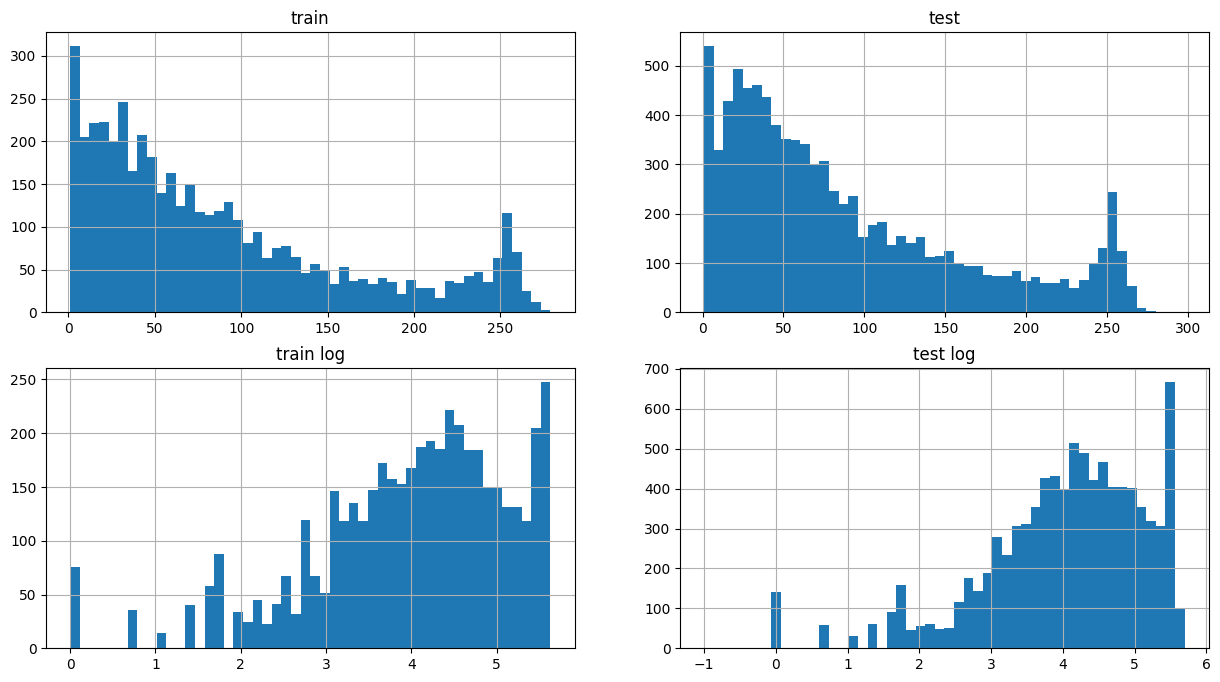

In [41]:
plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
plt.title('train')
train.text.str.len().hist(bins=50)
plt.subplot(2, 2, 2)
plt.title('test')
test.text.str.len().hist(bins=50)
plt.subplot(2, 2, 3)
plt.title('train log')
train.text.str.len().map(lambda x: np.log(x) if x > 0 else -1).hist(bins=50)
plt.subplot(2, 2, 4)
plt.title('test log')
test.text.str.len().map(lambda x: np.log(x) if x > 0 else -1).hist(bins=50)
plt.show()

In [42]:
df['text_len'] = df['text'].str.len()
df['text_len_log'] = df['text_len'].map(lambda x: np.log(x) if x > 0 else -1)

In [43]:
symbs = set()
for t in df.text.values:
    symbs.update(set(t.lower()))

symbs = list(symbs)
symbs = ''.join(symbs)

trash_symbs = re.findall(r'\W|ツ', symbs)
trash_symbs = ''.join(trash_symbs).replace(' ', '')

pattern = f'[{re.escape(trash_symbs)}]'

# example
t = df['text'].iloc[444].lower()
t, ' '.join(re.sub(pattern, ' ', t).split())

('заказ везут [num].[num] , у вас все хорошо? никогда больше заказывать у вас не будем! отвратительная работа службы поддержки и доставки!!!!',
 'заказ везут num num у вас все хорошо никогда больше заказывать у вас не будем отвратительная работа службы поддержки и доставки')

In [44]:
df['text'] = df['text'].map(lambda x: ' '.join(re.sub(pattern, ' ', x.lower()).split()))
df.head()

,assessment,tags,text,tags_num,no_tag,tags_ru,ASSORTMENT,CATALOG_NAVIGATION,DELIVERY,PAYMENT,PRICE,PRODUCTS_QUALITY,PROMOTIONS,SUPPORT,text_len,text_len_log
index,,,,,,,,,,,,,,,,
5652,6.0,ASSORTMENT PROMOTIONS DELIVERY,маленький выбор товаров хотелось бы ассортимен...,3,0,"ассортимент товаров, акции в магазине, качеств...",1,0,1,0,0,0,1,0,82,4.406719
18092,4.0,ASSORTMENT PRICE PRODUCTS_QUALITY DELIVERY,быстро,4,0,"ассортимент товаров, цены на продукты, качеств...",1,0,1,0,1,1,0,0,6,1.791759
13845,6.0,DELIVERY PROMOTIONS PRICE ASSORTMENT SUPPORT,доставка постоянно задерживается,5,0,"качество доставки, акции в магазине, цены на п...",1,0,1,0,1,0,1,1,32,3.465736
25060,6.0,PRICE PROMOTIONS ASSORTMENT,наценка и ассортимент расстраивают,3,0,"цены на продукты, акции в магазине, ассортимен...",1,0,0,0,1,0,1,0,34,3.526361
1428,6.0,PRICE PROMOTIONS,можно немного скинуть минимальную сумму заказа...,2,0,"цены на продукты, акции в магазине,",0,0,0,0,1,0,1,0,110,4.700480


# Learning

In [45]:
num_cols = ['assessment', 'tags_num', 'no_tag', 'text_len', 'text_len_log']
text_cols = ['tags', 'text']

In [46]:
train, test = update_df(train, test)
X = train[num_cols + text_cols]
X_test = test[num_cols + text_cols]
Y = train[target_cols]
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=SEED)

In [47]:
n_iter = 250
base_model = cb.CatBoostClassifier(iterations=n_iter, loss_function='CrossEntropy', 
                                   eval_metric='Accuracy', random_state=SEED, verbose=n_iter)
multi_model = MultiOutputClassifier(estimator=base_model)

multi_model.fit(X=X_train, Y=y_train,
                text_features=text_cols,
                plot=False,
                early_stopping_rounds=50)

0:	learn: 0.8883180	total: 50.3ms	remaining: 12.5s
249:	learn: 0.9191455	total: 14.2s	remaining: 0us
0:	learn: 0.9232017	total: 46.9ms	remaining: 11.7s
249:	learn: 0.9713359	total: 13.4s	remaining: 0us
0:	learn: 0.9029205	total: 46.3ms	remaining: 11.5s
249:	learn: 0.9424013	total: 13.9s	remaining: 0us
0:	learn: 0.9191455	total: 44.8ms	remaining: 11.2s
249:	learn: 0.9575446	total: 13.5s	remaining: 0us
0:	learn: 0.9718767	total: 46.7ms	remaining: 11.6s
249:	learn: 0.9816117	total: 13.4s	remaining: 0us
0:	learn: 0.9886425	total: 45.7ms	remaining: 11.4s
249:	learn: 0.9991888	total: 13.3s	remaining: 0us
0:	learn: 0.9954029	total: 50.2ms	remaining: 12.5s
249:	learn: 0.9981071	total: 13.2s	remaining: 0us
0:	learn: 0.9921579	total: 46.9ms	remaining: 11.7s
249:	learn: 0.9989183	total: 13.3s	remaining: 0us
0:	learn: 0.9702542	total: 46.9ms	remaining: 11.7s
249:	learn: 0.9897242	total: 13.2s	remaining: 0us
0:	learn: 0.9981071	total: 47.8ms	remaining: 11.9s
249:	learn: 1.0000000	total: 13.3s	remai

MultiOutputClassifier(estimator=<catboost.core.CatBoostClassifier object at 0x78106f198800>)

In [50]:
y_pred = multi_model.predict(X_val)
val_acc = accuracy_score(y_val, y_pred)
val_acc

0.3589189189189189

# Сабмит

In [51]:
X_test = test[num_cols + text_cols]
test_pool = cb.Pool(X_test, text_features=text_cols)
preds = multi_model.predict(test_pool)
sub = trg_to_sub(preds, indx=test.index)
sub.head()

,target
index,
3135,2
4655,12
22118,2
23511,0
45,NaN


In [123]:
sub.to_csv(DATA_DIR / f'sub_cb_{val_acc:.4f}_{SEED}.csv')